# Safe MLOps Deployment Pipeline


## Overview

In this notebook you will step through an MLOps pipeline to build, train, deploy and monitor an XGBoost regression model for predicting the expected taxi fare using the New York City Taxi [dataset](https://registry.opendata.aws/nyc-tlc-trip-records-pds/)⇗. This safe pipeline features a [canary deployment](https://docs.aws.amazon.com/wellarchitected/latest/machine-learning-lens/canary-deployment.html)⇗ strategy with rollback on error. You will learn how to trigger and monitor the pipeline, inspect the training workflow, use model monitor to set up alerts, and create a canary deployment.

<div class="alert alert-block alert-info">
    Note: This notebook assumes prior familiarity with the basics training ML models on Amazon SageMaker. Data preparation and visualization, although present, will be kept to a minimum. If you are not familiar with the basic concepts and features of SageMaker, we recommend reading the <a href=https://docs.aws.amazon.com/sagemaker/>SageMaker documentation</a>⇗ and completing the workshops and samples in <a href=https://github.com/aws/amazon-sagemaker-examples>AWS SageMaker Examples GitHub</a>⇗ and <a href=https://github.com/aws-samples?q=sagemaker&type=&language=>AWS Samples GitHub</a>⇗. 
</div>

### Contents

This notebook has the following key sections:

1. [Data Prep](#Data-Prep)
2. [Build](#Build)
3. [Train Model](#Train-Model)
4. [Deploy Dev](#Deploy-Dev)
5. [Deploy Prod](#Deploy-Prod)
6. [Monitor](#Monitor)
6. [Cleanup](#Cleanup)

### Architecture

The architecture diagram below shows the entire MLOps pipeline at a high level.

Use the CloudFormation template provided in this repository (`pipeline.yml`) to build the demo in your own AWS account. If you are currently viewing this notebook from SageMaker in your AWS account, then you have already completed this step. CloudFormation deploys several resources:
   
1. A customer-managed encryption key in in Amazon KMS for encrypting data and artifacts.
1. A secret in Amazon Secrets Manager to securely store your GitHub Access Token.
1. Several AWS IAM roles so CloudFormation, SageMaker, and other AWS services can perform actions in your AWS account, following the principle of [least privilege](https://docs.aws.amazon.com/IAM/latest/UserGuide/best-practices.html#grant-least-privilege)⇗.
1. A messaging service in Amazon SNS to notify you when CodeDeploy has successfully deployed the API, and to receive alerts for retraining and drift detection (signing up for these notifications is optional).
1. Two Amazon CloudWatch event rules: one which schedules the pipeline to run every month, and one which triggers the pipeline to run when SageMaker Model Monitor detects certain metrics.
1. An Amazon SageMaker Jupyter notebook with this workshop content pre-loaded.
1. An Amazon S3 bucket for storing model artifacts.
1. An AWS CodePipeline instance with several pre-defined stages. 

Take a moment to look at all of these resources now deployed in your account. 

![MLOps pipeline architecture](../docs/mlops-architecture.png)

In this notebook, you will work through the CodePipeline instance created by the CloudFormation template. It has several stages:

1. **Source** - The pipeline is already configured with two sources. If you upload a new dataset to a specific location in the S3 data bucket, this will trigger the pipeline to run. The Git source can be GitHub, or CodeCommit if you don’t supply your access token. If you commit new code to your repository, this will trigger the pipeline to run. 
1. **Build** - In this stage, CodeBuild configured by the build specification `model/buildspec.yml` will execute `model/run.py` to generate AWS CloudFormation templates for creating the AWS Step Function (including AWS Lambda custom resources), and deployment templates used in the following stages based on the data sets and hyperparameters specified for this pipeline run. You will take a closer look at these files later in this notebook. 
1. **Train** The Step Functions workflow created in the Build stage is run in this stage. The workflow creates a baseline for the model monitor using a SageMaker processing job, and trains an XGBoost model on the taxi ride dataset using a SageMaker training job.
1. **Deploy Dev** In this stage, a CloudFormation template created in the build stage (from `assets/deploy-model-dev.yml`) deploys a dev endpoint. This will allow you to run tests on the model and decide if the model is of sufficient quality to deploy into production.
1. **Deploy Production** The final stage of the pipeline is the only stage which does not run automatically as soon as the previous stage is complete. It waits for a user to manually approve the model which was previously deployed to dev. As soon as the model is approved, a CloudFormation template (packaged from `assets/deploy-model-prod.yml` to include the Lambda functions saved and uploaded as ZIP files in S3) deploys the production endpoint. It configures autoscaling and enables data capture. It creates a model monitoring schedule and sets CloudWatch alarms for certain metrics. It also sets up an AWS CodeDeploy instance which deploys a set of AWS Lambda functions and an Amazon API Gateway to sit in front of the SageMaker endpoint. This stage can make use of canary deployment to safely switch from an old model to a new model. 

In [1]:
# Import the latest sagemaker and boto3 SDKs.
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install -qU awscli boto3 "sagemaker>=2.1.0<3" tqdm
!{sys.executable} -m pip install -qU "stepfunctions==2.0.0"
!{sys.executable} -m pip show sagemaker stepfunctions

     |████████████████████████████████| 1.5 MB 16.9 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.0.1
    Uninstalling pip-21.0.1:
      Successfully uninstalled pip-21.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 1.2.1 requires botocore<1.19.53,>=1.19.52, but you have botocore 1.20.87 which is incompatible.
Name: sagemaker
Version: 2.44.0
Summary: Open source library for training and deploying models on Amazon SageMaker.
Home-page: https://github.com/aws/sagemaker-python-sdk/
Author: Amazon Web Services
Author-email: None
License: Apache License 2.0
Location: /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages
Requires: protobuf, google-pasta, importlib-metadata, packaging, pathos, attrs, pandas, protobuf3-to-dict, smdebug-rulesconfig, boto3, numpy
Required-by: stepfunctions
---
Name: step

Restart your SageMaker kernel then continue with this notebook.

## Data Prep
 
In this section of the notebook, you will download the publicly available New York Taxi dataset in preparation for uploading it to S3.

### Download Dataset

First, download a sample of the New York City Taxi [dataset](https://registry.opendata.aws/nyc-tlc-trip-records-pds/)⇗ to this notebook instance. This dataset contains information on trips taken by taxis and for-hire vehicles in New York City, including pick-up and drop-off times and locations, fares, distance traveled, and more. 

In [61]:
!aws s3 cp 's3://exp01-dev-modelexample-data/trip data/green_tripdata_2020-01.csv' 'nyc-tlc.csv'

download: s3://exp01-dev-modelexample-data/trip data/green_tripdata_2020-01.csv to ./nyc-tlc.csv


Now load the dataset into a pandas data frame, taking care to parse the dates correctly.

In [62]:
import pandas as pd

parse_dates= ['lpep_dropoff_datetime', 'lpep_pickup_datetime']
trip_df = pd.read_csv('nyc-tlc.csv', parse_dates=parse_dates)

trip_df.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2.0,2019-12-18 15:52:30,2019-12-18 15:54:39,N,1.0,264,264,5.0,0.00,3.5,0.50,0.5,0.01,0.0,NaN,0.3,4.81,1.0,1.0,0.00
1,2.0,2020-01-01 00:45:58,2020-01-01 00:56:39,N,5.0,66,65,2.0,1.28,20.0,0.00,0.0,4.06,0.0,NaN,0.3,24.36,1.0,2.0,0.00
2,2.0,2020-01-01 00:41:38,2020-01-01 00:52:49,N,1.0,181,228,1.0,2.47,10.5,0.50,0.5,3.54,0.0,NaN,0.3,15.34,1.0,1.0,0.00
3,1.0,2020-01-01 00:52:46,2020-01-01 01:14:21,N,1.0,129,263,2.0,6.30,21.0,3.25,0.5,0.00,0.0,NaN,0.3,25.05,2.0,1.0,2.75
4,1.0,2020-01-01 00:19:57,2020-01-01 00:30:56,N,1.0,210,150,1.0,2.30,10.0,0.50,0.5,0.00,0.0,NaN,0.3,11.30,1.0,1.0,0.00


### Data manipulation

Instead of the raw date and time features for pick-up and drop-off, let's use these features to calculate the total time of the trip in minutes, which will be easier to work with for our model.

In [63]:
trip_df['duration_minutes'] = (trip_df['lpep_dropoff_datetime'] - trip_df['lpep_pickup_datetime']).dt.seconds/60

The dataset contains a lot of columns we don't need, so let's select a sample of columns for our machine learning model. Keep only `total_amount` (fare), `duration_minutes`, `passenger_count`, and `trip_distance`.

In [64]:
cols = ['total_amount', 'duration_minutes', 'passenger_count', 'trip_distance']
data_df = trip_df[cols]
print(data_df.shape)
data_df.head()

(447770, 4)


,total_amount,duration_minutes,passenger_count,trip_distance
0,4.81,2.150000,5.0,0.00
1,24.36,10.683333,2.0,1.28
2,15.34,11.183333,1.0,2.47
3,25.05,21.583333,2.0,6.30
4,11.30,10.983333,1.0,2.30


Generate some quick statistics for the dataset to understand the quality.

In [65]:
data_df.describe()

,total_amount,duration_minutes,passenger_count,trip_distance
count,447770.000000,447770.000000,331719.000000,447770.000000
mean,18.898600,20.191509,1.304110,3.599392
std,14.101771,75.820894,0.953394,4.257709
min,-210.300000,0.000000,0.000000,-33.690000
25%,9.120000,7.000000,1.000000,1.080000
50%,14.400000,12.116667,1.000000,2.070000
75%,24.550000,21.000000,1.000000,4.410000
max,753.800000,1439.966667,9.000000,130.680000


The table above shows some clear outliers, e.g. -400 or 2626 as fare, or 0 passengers. There are many intelligent methods for identifying and removing outliers, but data cleaning is not the focus of this notebook, so just remove the outliers by setting some min and max values which seem more reasonable. Removing the outliers results in a final dataset of 754,671 rows.

In [66]:
data_df = data_df[(data_df.total_amount > 0) & (data_df.total_amount < 200) & 
                  (data_df.duration_minutes > 0) & (data_df.duration_minutes < 120) & 
                  (data_df.trip_distance > 0) & (data_df.trip_distance < 121) & 
                  (data_df.passenger_count > 0)].dropna()
print(data_df.shape)

(312891, 4)


### Data visualization

Since this notebook will build a regression model for the taxi data, it's a good idea to check if there is any correlation between the variables in our data. Use scatter plots on a sample of the data to compare trip distance with duration in minutes, and total amount (fare) with duration in minutes.

<AxesSubplot:xlabel='duration_minutes', ylabel='trip_distance'>

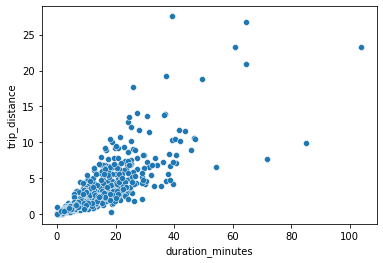

In [67]:
import seaborn as sns 

sample_df = data_df.sample(1000)
sns.scatterplot(data=sample_df, x='duration_minutes', y='trip_distance')

<AxesSubplot:xlabel='duration_minutes', ylabel='total_amount'>

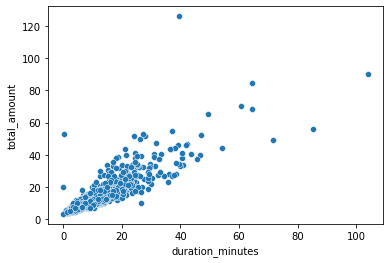

In [68]:
sns.scatterplot(data=sample_df, x='duration_minutes', y='total_amount')

These scatter plots look fine and show at least some correlation between our variables. 

### Data splitting and saving

We are now ready to split the dataset into train, validation, and test sets. 

In [69]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(data_df, test_size=0.20, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.05, random_state=42)

# Reset the index for our test dataframe
test_df.reset_index(inplace=True, drop=True)

print('Size of\n train: {},\n val: {},\n test: {} '.format(train_df.shape[0], val_df.shape[0], test_df.shape[0]))

Size of
 train: 250312,
 val: 59450,
 test: 3129 


Save the train, validation, and test files as CSV locally on this notebook instance. Notice that you save the train file twice - once as the training data file and once as the baseline data file. The baseline data file will be used by [SageMaker Model Monitor](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor.html)⇗ to detect data drift. Data drift occurs when the statistical nature of the data that your model receives while in production drifts away from the nature of the baseline data it was trained on, which means the model begins to lose accuracy in its predictions.

In [70]:
train_cols = ['total_amount', 'duration_minutes','passenger_count','trip_distance']
train_df.to_csv('train.csv', index=False, header=False)
val_df.to_csv('validation.csv', index=False, header=False)
test_df.to_csv('test.csv', index=False, header=False)

# Save test and baseline with headers
train_df.to_csv('baseline.csv', index=False, header=True)

In [71]:
import sagemaker

# Get the session and default bucket
session = sagemaker.session.Session()
#bucket = session.default_bucket()
bucket = "exp01-dev-modelexample-data"
print("Session: {0}, Bucket: {1}".format(session,bucket))

Session: <sagemaker.session.Session object at 0x7fa945501940>, Bucket: exp01-dev-modelexample-data


Now upload these CSV files to your default SageMaker S3 bucket. 

In [72]:
# Specify data prefix and version
prefix = 'modelsplit/v1'

s3_train_uri = session.upload_data('train.csv', bucket, prefix + '/data/training')
s3_val_uri = session.upload_data('validation.csv', bucket, prefix + '/data/validation')
s3_test_uri = session.upload_data('test.csv', bucket, prefix + '/data/test')
s3_baseline_uri = session.upload_data('baseline.csv', bucket, prefix + '/data/baseline')

You will use the datasets which you have prepared and saved in this section to trigger the pipeline to train and deploy a model in the next section.

## Build

If you navigate to the CodePipeline instance created for this workshop, you will notice that the Source stage is initially in a `Failed` state. This happens because the dataset, which is one of the sources that can trigger the pipeline, has not yet been uploaded to the S3 location expected by the pipeline.

![Failed code pipeline](../docs/pipeline_failed.png)

### Trigger Build

In this section, you will start a model build and deployment pipeline by packaging up the datasets you prepared in the previous section and uploading these to the S3 source location which triggers the CodePipeline instance created for this workshop. 

First, import some libraries and load some environment variables which you will need. These environment variables have been set through a  [lifecycle configuration](https://docs.aws.amazon.com/sagemaker/latest/dg/notebook-lifecycle-config.html)⇗ script attached to this notebook.

In [73]:
import boto3
from botocore.exceptions import ClientError
import os
import time

region = boto3.Session().region_name
artifact_bucket = os.environ['ARTIFACT_BUCKET']
pipeline_name = os.environ['PIPELINE_NAME']
model_name = os.environ['MODEL_NAME']
workflow_pipeline_arn = os.environ['WORKFLOW_PIPELINE_ARN']

print('region: {}'.format(region))
print('artifact bucket: {}'.format(artifact_bucket))
print('pipeline: {}'.format(pipeline_name))
print('model name: {}'.format(model_name))
print('workflow: {}'.format(workflow_pipeline_arn))

region: eu-west-1
artifact bucket: exp01-dev-modelexample-artifact
pipeline: exp01-dev-modelexample-pipeline
model name: modelexample
workflow: arn:aws:states:eu-west-1:342965497847:stateMachine:modelexample


From the AWS CodePipeline [documentation](https://docs.aws.amazon.com/codepipeline/latest/userguide/tutorials-simple-s3.html)⇗:

> When Amazon S3 is the source provider for your pipeline, you may zip your source file or files into a single .zip and upload the .zip to your source bucket. You may also upload a single unzipped file; however, downstream actions that expect a .zip file will fail.

To train a model, you need multiple datasets (train, validation, and test) along with a file specifying the hyperparameters. In this example, you will create one JSON file which contains the S3 dataset locations and one JSON file which contains the hyperparameter values. Then you compress both files into a zip package to be used as input for the pipeline run. 

In [74]:
from io import BytesIO
import zipfile
import json

input_data = {
    'TrainingUri': s3_train_uri,
    'ValidationUri': s3_val_uri,
    'TestUri': s3_test_uri,
    'BaselineUri': s3_baseline_uri
}

hyperparameters = {
    'num_round': 50
}

zip_buffer = BytesIO()
with zipfile.ZipFile(zip_buffer, 'a') as zf:
    zf.writestr('inputData.json', json.dumps(input_data))
    zf.writestr('hyperparameters.json', json.dumps(hyperparameters))
zip_buffer.seek(0)

data_source_key = '{}/data-source.zip'.format(model_name)

Now upload the zip package to your artifact S3 bucket - this action will trigger the pipeline to train and deploy a model.

In [75]:
s3 = boto3.client('s3')
s3.put_object(Bucket=artifact_bucket, Key=data_source_key, Body=bytearray(zip_buffer.read()))

{'ResponseMetadata': {'RequestId': 'G5GXQV6082NE8VBZ',
  'HostId': 'OH5qQFvOcvPbTs3V06XhNqJmYE7VFgS0Mqtzu3moftRz+ZQvAyqLLmiQwbWOkRd/zii0JyKaDbc=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'OH5qQFvOcvPbTs3V06XhNqJmYE7VFgS0Mqtzu3moftRz+ZQvAyqLLmiQwbWOkRd/zii0JyKaDbc=',
   'x-amz-request-id': 'G5GXQV6082NE8VBZ',
   'date': 'Fri, 04 Jun 2021 11:55:07 GMT',
   'x-amz-version-id': 'xDfDaEeQi3UeIsDlhKsD7jA8qMtvREhI',
   'etag': '"a3ed5d021a5cd7a3c6fcceed4bc26f8e"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"a3ed5d021a5cd7a3c6fcceed4bc26f8e"',
 'VersionId': 'xDfDaEeQi3UeIsDlhKsD7jA8qMtvREhI'}

Click the link below to open the AWS console at the Code Pipeline if you don't have it open in another tab.

<div class="alert alert-block alert-info">
    Tip: You may need to wait a minute to see the DataSource stage turn green. The page will refresh automatically.
</div>

![Source Green](../docs/datasource-after.png)

In [76]:
from IPython.core.display import HTML

HTML('<a target="_blank" href="https://{0}.console.aws.amazon.com/codesuite/codepipeline/pipelines/{1}/view?region={0}">Code Pipeline</a>'.format(region, pipeline_name))

### Inspect Build Logs

Once the build stage is running, you will see the AWS CodeBuild job turn blue with a status of **In progress**.

![Failed code pipeline](../docs/codebuild-inprogress.png)

You can click on the **Details** link displayed in the CodePipeline UI or click the link below to jump directly to the CodeBuild logs.

<div class="alert alert-block alert-info">
    Tip: You may need to wait a few seconds for the pipeline to transition into the active (blue) state and for the build to start.
</div>

In [77]:
codepipeline = boto3.client('codepipeline')

def get_pipeline_stage(pipeline_name, stage_name):
    response = codepipeline.get_pipeline_state(name=pipeline_name)
    for stage in response['stageStates']:
        if stage['stageName'] == stage_name:
            return stage

# Get last execution id
build_stage = get_pipeline_stage(pipeline_name, 'Build')    
if not 'latestExecution' in build_stage:
    raise(Exception('Please wait.  Build not started'))

build_url = build_stage['actionStates'][0]['latestExecution']['externalExecutionUrl']

# Out a link to the code build logs
HTML('<a target="_blank" href="{0}">Code Build Logs</a>'.format(build_url))

The AWS CodeBuild process is responsible for creating a number of AWS CloudFormation templates which we will explore in more detail in the next section.  Two of these templates are used to set up the **Train** step by creating the AWS Step Functions worklow and the custom AWS Lambda functions used within this workflow.

## Train Model

### Inspect Training Job

Wait until the pipeline has started running the Train step (see screenshot) before continuing with the next cells in this notebook. 

![Training in progress](../docs/train-in-progress.png)

When the pipeline has started running the train step, you can click on the **Details** link displayed in the CodePipeline UI (see screenshot above) to view the Step Functions workflow which is running the training job. 

Alternatively, you can click on the Workflow link from the cell output below once it's available.

In [78]:
from stepfunctions.workflow import Workflow
while True:
    try:
        workflow = Workflow.attach(workflow_pipeline_arn)
        break
    except ClientError as e:
        print(e.response["Error"]["Message"])
    time.sleep(10)

workflow

Workflow(name='modelexample', role='arn:aws:iam::342965497847:role/exp01-dev-modelexample-sfn-execution-role', state_machine_arn='arn:aws:states:eu-west-1:342965497847:stateMachine:modelexample')

Or simply run the cell below to display the Step Functions workflow, and re-run it after a few minutes to see the progress.

In [79]:
executions = workflow.list_executions()
if not executions:
    raise(Exception('Please wait.  Training not started'))
    
executions[0].render_progress()

### Review Build Script

While you wait for the training job to complete, let's take a look at the `run.py` code which was used by the AWS CodeBuild process.

This script takes all of the input parameters, including the dataset locations and hyperparameters which you saved to JSON files earlier in this notebook, and uses them to generate the templates which the pipeline needs to run the training job. It *does not* create the actual Step Functions instance - it only generates the templates which define the Step Functions workflow, as well as the CloudFormation input templates which CodePipeline uses to instantiate the Step Functions instance.

Step-by-step, the script does the following:

1. It collects all the input parameters it needs to generate the templates. This includes information about the environment container needed to run the training job, the input and output data locations, IAM roles needed by various components, encryption keys, and more. It then sets up some basic parameters like the AWS region and the function names.
1. If the input parameters specify an environment container stored in ECR, it fetches that container. Otherwise, it fetches the URI of the AWS managed environment container needed for the training job.
1. It reads the input data JSON file which you generated earlier in this notebook (and which was included in the zip source for the pipeline), thereby fetching the locations of the train, validation, and baseline data files. Then it formats more parameters which will be needed later in the script, including version IDs and output data locations.
1. It reads the hyperparameter JSON file which you generated earlier in this notebook.
1. It defines the Step Functions workflow, starting with the input schema, followed by each step of the workflow (i.e. Create Experiment, Baseline Job, Training Job), and finally combines those steps into a workflow graph. 
1. The workflow graph is saved to file, along with a file containing all of the input parameters saved according to the schema defined in the workflow.
1. It saves parameters to file which will be used by CloudFormation to instantiate the Step Functions workflow.

In [80]:
!pygmentize ../model/run.py

import argparse
import json
import os
import sys
import time

import boto3

import sagemaker
from sagemaker.image_uris import retrieve
from sagemaker.processing import Processor, ProcessingInput, ProcessingOutput
from sagemaker.model_monitor.dataset_format import DatasetFormat

import stepfunctions
from stepfunctions import steps
from stepfunctions.inputs import ExecutionInput
from stepfunctions.workflow import Workflow


def create_experiment_step(create_experiment_function_name):
    create_experiment_step = steps.compute.LambdaStep(
        "Create Experiment",
        parameters={
            "FunctionName": create_experiment_function_name,
            "Payload": {"ExperimentName.$": "$.ExperimentName", "TrialName.$": "$.TrialName",},
        },
        result_path="$.CreateTrialResults",
    )
    return create_experiment_step


def create_baseline_step(input_data, execution_input, region, role):
    # Define the enviornment
    dataset_format = DatasetFormat.csv()
    env = {
   

### Customize Workflow (Optional)

If you are interested in customising the workflow used in the Build Script, store the `input_data` to be used within the local [workflow.ipynb](workflow.ipynb) notebook. The workflow notebook can be used to experiment with the Step Functions workflow and training job definitions for your model.

In [81]:
%store input_data

Stored 'input_data' (dict)


### Training Analytics

Once the training and baseline jobs are complete (meaning they are displayed in a green color in the Step Functions workflow, this takes around 5 minutes), you can inspect the experiment metrics. The code below will display all experiments in a table. Note that the baseline processing job won't have RMSE metrics - it calculates metrics based on the training data, but does not train a machine learning model. 

You will [explore the baseline](#Explore-Baseline) results later in this notebook. <a id="validation-results"></a>

In [59]:
'''
import boto3
sm = boto3.Session().client('sagemaker')

def cleanup_boto3(experiment_name):
    trials = sm.list_trials(ExperimentName=experiment_name)['TrialSummaries']
    print('TrialNames:')
    for trial in trials:
        trial_name = trial['TrialName']
        print(f"\n{trial_name}")

        components_in_trial = sm.list_trial_components(TrialName=trial_name)
        print('\tTrialComponentNames:')
        for component in components_in_trial['TrialComponentSummaries']:
            component_name = component['TrialComponentName']
            print(f"\t{component_name}")
            sm.disassociate_trial_component(TrialComponentName=component_name, TrialName=trial_name)
            try:
                # comment out to keep trial components
                sm.delete_trial_component(TrialComponentName=component_name)
            except:
                # component is associated with another trial
                continue
            # to prevent throttling
            time.sleep(.5)
        sm.delete_trial(TrialName=trial_name)
    sm.delete_experiment(ExperimentName=experiment_name)
    print(f"\nExperiment {experiment_name} deleted")
    
# Use experiment name not display name
experiment_name = 'mlops-ModelExample'
cleanup_boto3(experiment_name)
'''

TrialNames:

mlops-ModelExample-1623dab1-0342-46f1-8dea-4b4de8ff7ed1
	TrialComponentNames:
	mlops-ModelExample-1623dab1-0342-46f1-8dea-4b4de8ff7ed1-aws-training-job
	mlops-modelexample-pbl-1623dab1-0342-46f1-8dea-4b4de8ff7ed1-aws-processing-job

mlops-ModelExample-8737d433-e952-4e50-bf87-ee9eac1bde06
	TrialComponentNames:

Experiment mlops-ModelExample deleted


In [82]:
from sagemaker import analytics
experiment_name = 'mlops-{}'.format(model_name)
model_analytics = analytics.ExperimentAnalytics(experiment_name=experiment_name)
analytics_df = model_analytics.dataframe()
model_analytics.dataframe

<bound method AnalyticsMetricsBase.dataframe of <sagemaker.ExperimentAnalytics for mlops-modelexample>>

In [83]:
if (analytics_df.shape[0] == 0):
    raise(Exception('Please wait.  No training or baseline jobs'))

pd.set_option('display.max_colwidth', 100) # Increase column width to show full copmontent name
cols = ['TrialComponentName', 'DisplayName', 'SageMaker.InstanceType', 
        'train:rmse - Last', 'validation:rmse - Last'] # return the last rmse for training and validation
analytics_df[analytics_df.columns & cols].head(2)

,TrialComponentName,DisplayName,SageMaker.InstanceType,train:rmse - Last,validation:rmse - Last
0,mlops-modelexample-pbl-18714106-0eaa-48ad-924d-804c7a5b6392-aws-processing-job,Baseline,ml.m5.xlarge,NaN,NaN
1,mlops-modelexample-18714106-0eaa-48ad-924d-804c7a5b6392-aws-training-job,Training,ml.m4.xlarge,3.67031,3.65409


## Deploy Dev

### Test Dev Deployment

When the pipeline has finished training a model, it automatically moves to the next step, where the model is deployed as a SageMaker Endpoint. This endpoint is part of your dev deployment, therefore, in this section, you will run some tests on the endpoint to decide if you want to deploy this model into production.

First, run the cell below to fetch the name of the SageMaker Endpoint.

In [84]:
codepipeline = boto3.client('codepipeline')

deploy_dev = get_pipeline_stage(pipeline_name, 'DeployDev')
if not 'latestExecution' in deploy_dev:
    raise(Exception('Please wait.  Deploy dev not started'))
    
execution_id = deploy_dev['latestExecution']['pipelineExecutionId']
dev_endpoint_name = 'mlops-{}-dev-{}'.format(model_name, execution_id)

print('endpoint name: {}'.format(dev_endpoint_name))

endpoint name: mlops-modelexample-dev-18714106-0eaa-48ad-924d-804c7a5b6392


If you moved through the previous section very quickly, you will need to wait until the dev endpoint has been successfully deployed and the pipeline is waiting for approval to deploy to production (see screenshot). It can take up to 10 minutes for SageMaker to create an endpoint.

![Deploying dev endpoint in code pipeline](../docs/dev-deploy-ready.png)

Alternatively, run the code below to check the status of your endpoint. Wait until the status of the endpoint is 'InService'.

In [85]:
sm = boto3.client('sagemaker')

while True:
    try:
        response = sm.describe_endpoint(EndpointName=dev_endpoint_name)
        print("Endpoint status: {}".format(response['EndpointStatus']))
        if response['EndpointStatus'] == 'InService':
            break
    except ClientError as e:
        print(e.response["Error"]["Message"])
    time.sleep(10)

Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint sta

Now that your endpoint is ready, let's write some code to run the test data (which you split off from the dataset and saved to file at the start of this notebook) through the endpoint for inference. The code below supports both v1 and v2 of the SageMaker SDK, but we recommend using v2 of the SDK in all of your future projects.

In [86]:
import numpy as np
from tqdm import tqdm

try:
    # Support SageMaker v2 SDK: https://sagemaker.readthedocs.io/en/stable/v2.html
    from sagemaker.predictor import Predictor
    from sagemaker.serializers import CSVSerializer
    def get_predictor(endpoint_name):
        xgb_predictor = Predictor(endpoint_name)
        xgb_predictor.serializer = CSVSerializer()
        return xgb_predictor
except:
    # Fallback to SageMaker v1.70 SDK
    from sagemaker.predictor import RealTimePredictor, csv_serializer
    def get_predictor(endpoint_name):
        xgb_predictor = RealTimePredictor(endpoint_name)
        xgb_predictor.content_type = 'text/csv'
        xgb_predictor.serializer = csv_serializer
        return xgb_predictor

def predict(predictor, data, rows=500):
    split_array = np.array_split(data, round(data.shape[0] / float(rows)))
    predictions = ''
    for array in tqdm(split_array):
        predictions = ','.join([predictions, predictor.predict(array).decode('utf-8')])
    return np.fromstring(predictions[1:], sep=',')

Now use the `predict` function, which was defined in the code above, to run the test data through the endpoint and generate the predictions.

In [87]:
dev_predictor = get_predictor(dev_endpoint_name)
predictions = predict(dev_predictor, test_df[test_df.columns[1:]].values)

100%|██████████| 6/6 [00:00<00:00, 20.83it/s]


Next, load the predictions into a data frame, and join it with your test data. Then, calculate absolute error as the difference between the actual taxi fare and the predicted taxi fare. Display the results in a table, sorted by the highest absolute error values.

In [88]:
pred_df = pd.DataFrame({'total_amount_predictions': predictions })
pred_df = test_df.join(pred_df) # Join on all
pred_df['error'] = abs(pred_df['total_amount']-pred_df['total_amount_predictions'])

pred_df.sort_values('error', ascending=False).head()

,total_amount,duration_minutes,passenger_count,trip_distance,total_amount_predictions,error
64,130.80,84.533333,2.0,0.52,22.481468,108.318532
1117,103.86,18.583333,1.0,3.50,19.095339,84.764661
142,90.50,6.266667,2.0,2.90,12.548207,77.951793
1953,78.10,20.133333,5.0,6.00,26.407524,51.692476
2095,50.30,1.166667,4.0,0.09,6.508444,43.791556


From this table, we note that some short trip distances have large errors because the low predicted fare does not match the high actual fare. This could be the result of a generous tip which we haven't included in this dataset.

You can also analyze the results by plotting the absolute error to visualize outliers. In this graph, we see that most of the outliers are cases where the model predicted a much lower fare than the actual fare. There are only a few outliers where the model predicted a higher fare than the actual fare.

<AxesSubplot:xlabel='total_amount_predictions', ylabel='total_amount'>

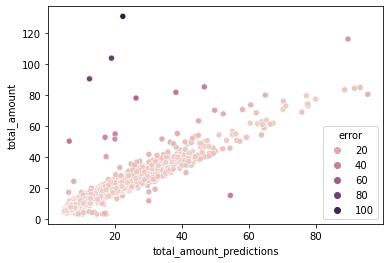

In [89]:
sns.scatterplot(data=pred_df, x='total_amount_predictions', y='total_amount', hue='error')

If you want one overall measure of quality for the model, you can calculate the root mean square error (RMSE) for the predicted fares compared to the actual fares. Compare this to the [results calculated on the validation set](#validation-results) at the end of the 'Inspect Training Job' section.

In [90]:
from math import sqrt
from sklearn.metrics import mean_squared_error

def rmse(pred_df):
    return sqrt(mean_squared_error(pred_df['total_amount'], pred_df['total_amount_predictions']))

print('RMSE: {}'.format(rmse(pred_df)))

RMSE: 4.395918149503103


## Deploy Prod

### Approve Deployment to Production

If you are happy with the results of the model, you can go ahead and approve the model to be deployed into production. You can do so by clicking the **Review** button in the CodePipeline UI, leaving a comment to explain why you approve this model, and clicking on **Approve**. 

Alternatively, you can create a Jupyter widget which (when enabled) allows you to comment and approve the model directly from this notebook. Run the cell below to see this in action.

In [93]:
import ipywidgets as widgets

def on_click(obj):
    result = { 'summary': approval_text.value, 'status': obj.description }
    response = codepipeline.put_approval_result(
      pipelineName=pipeline_name,
      stageName='DeployDev',
      actionName='ApproveDeploy',
      result=result,
      token=approval_action['token']
    )
    button_box.close()
    print(result)
    
# Create the widget if we are ready for approval
deploy_dev = get_pipeline_stage(pipeline_name, 'DeployDev')
if not 'latestExecution' in deploy_dev['actionStates'][-1]:
    raise(Exception('Please wait.  Deploy dev not complete'))

approval_action = deploy_dev['actionStates'][-1]['latestExecution']
if approval_action['status'] == 'Succeeded':
    print('Dev approved: {}'.format(approval_action['summary']))
elif 'token' in approval_action:
    approval_text = widgets.Text(placeholder='Optional approval message')   
    approve_btn = widgets.Button(description="Approved", button_style='success', icon='check')
    reject_btn = widgets.Button(description="Rejected", button_style='danger', icon='close')
    approve_btn.on_click(on_click)
    reject_btn.on_click(on_click)
    button_box = widgets.HBox([approval_text, approve_btn, reject_btn])
    display(button_box)
else:
    raise(Exception('Please wait. No dev approval'))

Dev approved: Approved by arn:aws:iam::342965497847:user/adminsaravg


In [ ]:
deploy_prd = get_pipeline_stage(pipeline_name, 'DeployPrd')

### Test Production Deployment

Within about a minute after approving the model deployment, you should see the pipeline start on the final step: deploying your model into production. In this section, you will check the deployment status and test the production endpoint after it has been deployed.

![Deploy production endpoint in code pipeline](../docs/deploy-production.png)

This step of the pipeline uses CloudFormation to deploy a number of resources on your behalf. In particular, it creates:

1. A production-ready SageMaker Endpoint for your model, with [data capture](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-data-capture.html)⇗  (used by SageMaker Model Monitor) and [autoscaling](https://docs.aws.amazon.com/sagemaker/latest/dg/endpoint-auto-scaling.html)⇗ enabled.
1. A [model monitoring schedule](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-scheduling.html)⇗ which outputs the results to CloudWatch metrics, along with a [CloudWatch Alarm](https://docs.aws.amazon.com/AmazonCloudWatch/latest/monitoring/AlarmThatSendsEmail.html)⇗ which will notify you when a violation occurs. 
1. A CodeDeploy instance which creates a simple app by deploying API Gateway, three Lambda functions, and an alarm to notify of the success or failure of this deployment. The code for the Lambda functions can be found in `api/app.py`, `api/pre_traffic_hook.py`, and `api/post_traffic_hook.py`. These functions update the endpoint to enable data capture, format and submit incoming traffic to the SageMaker endpoint, and capture the data logs.

![Components of production deployment](../docs/cloud-formation.png)

Let's check how the deployment is progressing. Use the code below to fetch the execution ID of the depoyment step. Then generate a table which lists the resources created by the CloudFormation stack and their creation status. You can re-run the cell after a few minutes to see how the steps are progressing.

In [102]:
deploy_prd = get_pipeline_stage(pipeline_name, 'DeployPrd')
deploy_prd

ClientError: An error occurred (AccessDeniedException) when calling the GetPipelineState operation: User: arn:aws:sts::342965497847:assumed-role/exp01-dev-modelexample-sagemaker-role/SageMaker is not authorized to perform: codepipeline:GetPipelineState on resource: arn:aws:codepipeline:eu-west-1:342965497847:modelexample

In [99]:

if not 'latestExecution' in deploy_prd or not 'latestExecution' in deploy_prd['actionStates'][0]:
    raise(Exception('Please wait.  Deploy prd not started'))

execution_id = deploy_prd['latestExecution']['pipelineExecutionId']

TypeError: argument of type 'NoneType' is not iterable

In [ ]:
from datetime import datetime, timedelta
from dateutil.tz import tzlocal

def get_event_dataframe(events):
    stack_cols = ['LogicalResourceId', 'ResourceStatus', 'ResourceStatusReason', 'Timestamp']
    stack_event_df = pd.DataFrame(events)[stack_cols].fillna('')
    stack_event_df['TimeAgo'] = (datetime.now(tzlocal())-stack_event_df['Timestamp'])
    return stack_event_df.drop('Timestamp', axis=1)

cfn = boto3.client('cloudformation')

stack_name = stack_name='{}-deploy-prd'.format(pipeline_name)
print('stack name: {}'.format(stack_name))

# Get latest stack events
while True:
    try:
        response = cfn.describe_stack_events(StackName=stack_name)
        break
    except ClientError as e:
        print(e.response["Error"]["Message"])
    time.sleep(10)
    
get_event_dataframe(response['StackEvents']).head()

The resource of most interest to us is the endpoint. This takes on average 10 minutes to deploy.  In the meantime, you can take a look at the Python code used for the application. 

The `app.py` is the main entry point invoking the Amazon SageMaker endpoint.  It returns results along with a custom header for the endpoint we invoked.

In [ ]:
!pygmentize ../api/app.py

The `pre_traffic_hook.py` lambda is invoked prior to deployment and confirms the endpoint has data capture enabled.

In [ ]:
!pygmentize ../api/pre_traffic_hook.py

The `post_traffic_hook.py` lambda is invoked to perform any final checks, in this case to verify that we have received log data from data capature.

In [ ]:
!pygmentize ../api/post_traffic_hook.py

Use the code below to fetch the name of the endpoint, then run a loop to wait for the endpoint to be fully deployed. You need the status to be 'InService'.

In [ ]:
prd_endpoint_name='mlops-{}-prd-{}'.format(model_name, execution_id)
print('prod endpoint: {}'.format(prd_endpoint_name))

In [ ]:
sm = boto3.client('sagemaker')

while True:
    try:
        response = sm.describe_endpoint(EndpointName=prd_endpoint_name)
        print("Endpoint status: {}".format(response['EndpointStatus']))
        # Wait until the endpoint is in service with data capture enabled
        if response['EndpointStatus'] == 'InService' \
            and 'DataCaptureConfig' in response \
            and response['DataCaptureConfig']['EnableCapture']:
            break
    except ClientError as e:
        print(e.response["Error"]["Message"])
    time.sleep(10)

When the endpoint status is 'InService', you can continue. Earlier in this notebook, you created some code to send data to the dev endpoint. Reuse this code now to send a sample of the test data to the production endpoint. Since data capture is enabled on this endpoint, you want to send single records at a time, so the model monitor can map these records to the baseline. 

You will [inspect the model monitor](#Inspect-Model-Monitor) later in this notebook. For now, just check if you can send data to the endpoint and receive predictions in return.

In [ ]:
prd_predictor = get_predictor(prd_endpoint_name)
sample_values = test_df[test_df.columns[1:]].sample(100).values
predictions = predict(prd_predictor, sample_values, rows=1)
predictions

### Test REST API

Although you already tested the SageMaker endpoint in the previous section, it is also a good idea to test the application created with API Gateway. 

![Traffic shift between endpoints](../docs/lambda-deploy-create.png)

Follow the link below to open the Lambda Deployment where you can see the in-progress and completed deployments. You can also click to expand the **SAM template** to see the packaged CloudFormation template used in the deployment.

In [ ]:
HTML('<a target="_blank" href="https://{0}.console.aws.amazon.com/lambda/home?region={0}#/applications/{1}-deploy-prd?tab=deploy">Lambda Deployment</a>'.format(region, model_name))

Run the code below to confirm that the endpoint is in service.  It will complete once the REST API is available.

In [ ]:
def get_stack_status(stack_name):
    response = cfn.describe_stacks(StackName=stack_name)
    if response['Stacks']:
        stack = response['Stacks'][0]
        outputs = None
        if 'Outputs' in stack:
            outputs = dict([(o['OutputKey'], o['OutputValue']) for o in stack['Outputs']])
        return stack['StackStatus'], outputs 

outputs = None
while True:
    try:
        status, outputs = get_stack_status(stack_name)
        response = sm.describe_endpoint(EndpointName=prd_endpoint_name)
        print("Endpoint status: {}".format(response['EndpointStatus']))
        if outputs:
            break
        elif status.endswith('FAILED'):
            raise(Exception('Stack status: {}'.format(status)))
    except ClientError as e:
        print(e.response["Error"]["Message"])
    time.sleep(10)

if outputs:
    print('deployment application: {}'.format(outputs['DeploymentApplication']))
    print('rest api: {}'.format(outputs['RestApi']))

If you are performing an update on your production deployment as a result of running [Trigger Retraining](#Trigger-Retraining) you will then be able to expand the Lambda Deployment tab to reveal the resources. Click on the **ApiFunctionAliaslive** link to see the Lambda Deployment in progress. 

![Traffic shift between endpoints](../docs/lambda-deploy-update.png)

This page will be updated to list the deployment events.  It also has a link to the Deployment Application which you can access in the output of the next cell.

In [ ]:
HTML('<a target="_blank" href="https://{0}.console.aws.amazon.com/codesuite/codedeploy/applications/{1}?region={0}">CodeDeploy application</a>'.format(region, outputs['DeploymentApplication']))

CodeDeploy will perform a canary deployment and send 10% of the traffic to the new endpoint over a 5-minute period.

![Traffic shift between endpoints](../docs/code-deploy.gif)

We can invoke the REST API and inspect the headers being returned to see which endpoint we are hitting.  You will occasionally see the cell below show a different endpoint that settles to the new version once the stack is complete.  

In [ ]:
%%time

from urllib import request

headers = {"Content-type": "text/csv"}
payload = test_df[test_df.columns[1:]].head(1).to_csv(header=False, index=False).encode('utf-8')
rest_api = outputs['RestApi']

while True:
    try:
        resp = request.urlopen(request.Request(rest_api, data=payload, headers=headers))
        print("Response code: %d: endpoint: %s" % (resp.getcode(), resp.getheader('x-sagemaker-endpoint')))
        status, outputs = get_stack_status(stack_name) 
        if status.endswith('COMPLETE'):
            print('Deployment complete\n')
            break
        elif status.endswith('FAILED'):
            raise(Exception('Stack status: {}'.format(status)))
    except ClientError as e:
        print(e.response["Error"]["Message"])
    time.sleep(10)

## Monitor

### Inspect Model Monitor

When you prepared the datasets for model training at the start of this notebook, you saved a baseline dataset (a copy of the train dataset). Then, when you approved the model for deployment into production, the pipeline set up an SageMaker Endpoint with data capture enabled and a model monitoring schedule. In this section, you will take a closer look at the model monitor results.

To start off, fetch the latest production deployment execution ID.

In [ ]:
deploy_prd = get_pipeline_stage(pipeline_name, 'DeployPrd')
if not 'latestExecution' in deploy_prd:
    raise(Exception('Please wait.  Deploy prod not complete'))
    
execution_id = deploy_prd['latestExecution']['pipelineExecutionId']

Under the hood, SageMaker model monitor runs in SageMaker processing jobs. Use the execution ID to fetch the names of the processing job and the schedule.

In [ ]:
processing_job_name='mlops-{}-pbl-{}'.format(model_name, execution_id)
schedule_name='mlops-{}-pms'.format(model_name)

print('processing job name: {}'.format(processing_job_name))
print('schedule name: {}'.format(schedule_name))

### Explore Baseline

Now fetch the baseline results from the processing job. This cell will throw an exception if the processing job is not complete - if that happens, just wait several minutes and try again. <a id="view-baseline-results"></a>

In [ ]:
import sagemaker
from sagemaker.model_monitor import BaseliningJob, MonitoringExecution
from sagemaker.s3 import S3Downloader

sagemaker_session = sagemaker.Session()
baseline_job = BaseliningJob.from_processing_name(sagemaker_session, processing_job_name)
status = baseline_job.describe()['ProcessingJobStatus']
if status != 'Completed':
    raise(Exception('Please wait. Processing job not complete, status: {}'.format(status)))
    
baseline_results_uri  = baseline_job.outputs[0].destination

SageMaker model monitor generates two types of files. Take a look at the statistics file first. It calculates various statistics for each feature of the dataset, including the mean, standard deviation, minimum value, maximum value, and more. 

In [ ]:
import pandas as pd
import json

baseline_statistics = baseline_job.baseline_statistics().body_dict
schema_df = pd.json_normalize(baseline_statistics["features"])
schema_df[["name", "numerical_statistics.mean", "numerical_statistics.std_dev",
           "numerical_statistics.min", "numerical_statistics.max"]].head()

Now look at the suggested [constraints files](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-byoc-constraints.html)⇗. As the name implies, these are constraints which SageMaker model monitor recommends. If the live data which is sent to your production SageMaker Endpoint violates these constraints, this indicates data drift, and model monitor can raise an alert to trigger retraining. Of course, you can set different constraints based on the statistics which you viewed previously.

In [ ]:
baseline_constraints = baseline_job.suggested_constraints().body_dict
constraints_df = pd.json_normalize(baseline_constraints["features"])
constraints_df.head()

### View data capture

When the "Deploy Production" stage of the MLOps pipeline deploys a SageMaker endpoint, it also enables data capture. This means the incoming requests to the endpoint, as well as the results from the ML model, are stored in an S3 location. Model monitor can analyze this data and compare it to the baseline to ensure that no constraints are violated. 

Use the code below to check how many files have been created by the data capture, and view the latest file in detail. Note, data capture relies on data being sent to the production endpoint. If you don't see any files yet, wait several minutes and try again.

In [ ]:
bucket = sagemaker_session.default_bucket()
data_capture_logs_uri = 's3://{}/{}/datacapture/{}'.format(bucket, model_name, prd_endpoint_name)

capture_files = S3Downloader.list(data_capture_logs_uri)
print('Found {} files'.format(len(capture_files)))

if capture_files:
    # Get the first line of the most recent file    
    event = json.loads(S3Downloader.read_file(capture_files[-1]).split('\n')[0])
    print('\nLast file:\n{}'.format(json.dumps(event, indent=2)))

### View monitoring schedule

There are some useful functions for plotting and rendering distribution statistics or constraint violations provided in a `utils` file in the [SageMaker Examples GitHub](https://github.com/aws/amazon-sagemaker-examples/tree/master/sagemaker_model_monitor/visualization)⇗. Grab a copy of this code to use in this notebook. 

In [ ]:
!wget -O utils.py --quiet https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/master/sagemaker_model_monitor/visualization/utils.py
import utils as mu

The [minimum scheduled run time](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-scheduling.html)⇗ for model monitor is one hour, which means you will need to wait at least an hour to see any results. Use the code below to check the schedule status and list the next run. If you are completing this notebook as part of a workshop, your host will have activities which you can complete while you wait. 

In [ ]:
sm = boto3.client('sagemaker')

response = sm.describe_monitoring_schedule(MonitoringScheduleName=schedule_name)
print('Schedule Status: {}'.format(response['MonitoringScheduleStatus']))

now = datetime.now(tzlocal())
next_hour = (now+timedelta(hours=1)).replace(minute=0)
scheduled_diff = (next_hour-now).seconds//60
print('Next schedule in {} minutes'.format(scheduled_diff))

While you wait, you can take a look at the CloudFormation template which is used as a base for the CloudFormation template built by CodeDeploy to deploy the production application. 

Alterntively, you can jump ahead to [Trigger Retraining](#Trigger-Retraining) which will kick off another run of the code pipeline whilst you wait.

In [ ]:
!cat ../assets/deploy-model-prd.yml

A couple of minutes after the model monitoring schedule has run, you can use the code below to fetch the latest schedule status.  A completed schedule run may have found violations. 

In [ ]:
processing_job_arn = None

while processing_job_arn == None:
    try:
        response = sm.list_monitoring_executions(MonitoringScheduleName=schedule_name)
    except ClientError as e:
        print(e.response["Error"]["Message"])
    for mon in response['MonitoringExecutionSummaries']:
        status = mon['MonitoringExecutionStatus']
        now = datetime.now(tzlocal())
        created_diff = (now-mon['CreationTime']).seconds//60
        print('Schedule status: {}, Created: {} minutes ago'.format(status, created_diff))
        if status in ['Completed', 'CompletedWithViolations']:
            processing_job_arn = mon['ProcessingJobArn']
            break
        if status == 'InProgress':
            break
    else:
        raise(Exception('Please wait.  No Schedules executing'))
    time.sleep(10)

### View monitoring results

Once the model monitoring schedule has had a chance to run at least once, you can take a look at the results. First, load the monitoring execution results from the latest scheduled run.

In [ ]:
if processing_job_arn:
    execution = MonitoringExecution.from_processing_arn(sagemaker_session=sagemaker.Session(),
                                                        processing_job_arn=processing_job_arn)
    exec_inputs = {inp['InputName']: inp for inp in execution.describe()['ProcessingInputs']}
    exec_results_uri = execution.output.destination

    print('Monitoring Execution results: {}'.format(exec_results_uri))

Take a look at the files which have been saved in the S3 output location. If violations were found, you should see a constraint violations file in addition to the statistics and constraints file which you viewed before.

In [ ]:
!aws s3 ls $exec_results_uri/

Now, fetch the monitoring statistics and violations. Then use the utils code to visualize the results in a table. It will highlight any baseline drift found by the model monitor. Drift can happen for categorical features (for inferred string styles) or for numerical features (e.g. total fare amount).

In [ ]:
# Get the baseline and monitoring statistics & violations
baseline_statistics = baseline_job.baseline_statistics().body_dict
execution_statistics = execution.statistics().body_dict
violations = execution.constraint_violations().body_dict['violations']

In [ ]:
mu.show_violation_df(baseline_statistics=baseline_statistics, 
                     latest_statistics=execution_statistics, 
                     violations=violations)

### Trigger Retraining

The CodePipeline instance is configured with [CloudWatch Events](https://docs.aws.amazon.com/codepipeline/latest/userguide/create-cloudtrail-S3-source.html)⇗ to start the pipeline for retraining when the drift detection triggers specific metric alarms.

You can simulate drift by putting a metric value above the threshold of `0.2` directly into CloudWatch.  This will trigger the alarm, and start the code pipeline.

<div class="alert alert-block alert-info">
    Tip: This alarm is configured only for the latest production endpoint, so re-training will only occur if you are putting metrics against the latest endpoint.
</div>

![Metric graph in CloudWatch](../docs/cloudwatch-alarm.png)

Run the code below to trigger the metric alarm. The cell output will be a link to CloudWatch, where you can see the alarm (similar to the screenshot above), and a link to CodePipeline which you will see run again. Note that it can take a couple of minutes for everything to trigger.

In [ ]:
from datetime import datetime
import random

cloudwatch = boto3.client('cloudwatch')

# Define the metric name and threshold
metric_name = 'feature_baseline_drift_total_amount'
metric_threshold = 0.2

# Put a new metric to trigger an alaram
def put_drift_metric(value):
    print('Putting metric: {}'.format(value))
    response = cloudwatch.put_metric_data(
        Namespace='aws/sagemaker/Endpoints/data-metrics',
        MetricData=[
            {
                'MetricName': metric_name,
                'Dimensions': [
                    {
                        'Name': 'MonitoringSchedule',
                        'Value': schedule_name
                    },
                    {
                        'Name': 'Endpoint',
                        'Value': prd_endpoint_name
                    },
                ],
                'Timestamp': datetime.now(),
                'Value': value,
                'Unit': 'None'
            },
        ]
    )
    
def get_drift_stats():
    response = cloudwatch.get_metric_statistics(
        Namespace='aws/sagemaker/Endpoints/data-metrics',
        MetricName=metric_name,
        Dimensions=[
            {
                'Name': 'MonitoringSchedule',
                'Value': schedule_name
            },
            {
                'Name': 'Endpoint',
                'Value': prd_endpoint_name
            },
        ],
        StartTime=datetime.now() - timedelta(minutes=2),
        EndTime=datetime.now(),
        Period=1,
        Statistics=['Average'],
        Unit='None'
    )
    if 'Datapoints' in response and len(response['Datapoints']) > 0:        
        return response['Datapoints'][0]['Average']
    return 0    

print('Simluate drift on endpoint: {}'.format(prd_endpoint_name))

while True:
    put_drift_metric(round(random.uniform(metric_threshold, 1.0), 4))
    drift_stats = get_drift_stats()
    print('Average drift amount: {}'.format(get_drift_stats()))
    if drift_stats > metric_threshold:
        break
    time.sleep(1)

Click through to the Alarm and CodePipeline Execution history with the links below.

In [ ]:
# Output a html link to the cloudwatch dashboard
metric_alarm_name = 'mlops-{}-metric-gt-threshold'.format(model_name)
HTML('''<a target="_blank" href="https://{0}.console.aws.amazon.com/cloudwatch/home?region={0}#alarmsV2:alarm/{1}">CloudWatch Alarm</a> triggers
     <a target="_blank" href="https://{0}.console.aws.amazon.com/codesuite/codepipeline/pipelines/{2}/executions?region={0}">Code Pipeline Execution</a>'''.format(region, metric_alarm_name, pipeline_name))

Once the pipeline is running again you can jump back up to [Inspect Training Job](#Inspect-Training-Job)

### Create Synthetic Monitoring

[Amazon CloudWatch Synthetics](https://aws.amazon.com/blogs/aws/new-use-cloudwatch-synthetics-to-monitor-sites-api-endpoints-web-workflows-and-more/) allows you to monitor sites, REST APIs, and other services deployed on AWS. You can set up a canary to test that your REST API is returning an expected value at a regular interval. This is a great way to validate that the blue/green deployment is not causing any downtime for your end-users.

Use the code below to set up a canary to continuously test the production deployment. This canary simply pings the REST API to test if it is live, using code from `notebook/canary.js`.

In [ ]:
from urllib.parse import urlparse
from string import Template
from io import BytesIO
import zipfile

# Format the canary_js with rest_api and payload
rest_url = urlparse(rest_api)

with open('canary.js') as f:
    canary_js = Template(f.read()).substitute(hostname=rest_url.netloc, path=rest_url.path, 
                                              data=payload.decode('utf-8').strip())
# Write the zip file
zip_buffer = BytesIO()
with zipfile.ZipFile(zip_buffer, 'w') as zf:
    zip_path = 'nodejs/node_modules/apiCanaryBlueprint.js' # Set a valid path
    zip_info = zipfile.ZipInfo(zip_path)
    zip_info.external_attr = 0o0755 << 16 # Ensure the file is readable
    zf.writestr(zip_info, canary_js)
zip_buffer.seek(0)

# Create the canary
synth = boto3.client('synthetics')

role = sagemaker.get_execution_role()
s3_canary_uri = 's3://{}/{}'.format(artifact_bucket, model_name)
canary_name = 'mlops-{}'.format(model_name)

try:
    response = synth.create_canary(
        Name=canary_name,
        Code={
            'ZipFile': bytearray(zip_buffer.read()),
            'Handler': 'apiCanaryBlueprint.handler'
        },
        ArtifactS3Location=s3_canary_uri,
        ExecutionRoleArn=role,
        Schedule={ 
            'Expression': 'rate(10 minutes)', 
            'DurationInSeconds': 0 },
        RunConfig={
            'TimeoutInSeconds': 60,
            'MemoryInMB': 960
        },
        SuccessRetentionPeriodInDays=31,
        FailureRetentionPeriodInDays=31,
        RuntimeVersion='syn-nodejs-2.0',
    )
    print('Creating canary: {}'.format(canary_name))    
except ClientError as e:
    if e.response["Error"]["Code"] == "AccessDeniedException":
        print('Canary not supported.') # Not supported in event engine
    else:
        raise(e)

Now create a CloudWatch alarm which will trigger if the success rate of the canary drops below 90%. 

In [ ]:
cloudwatch = boto3.client('cloudwatch')

canary_alarm_name = '{}-synth-lt-threshold'.format(canary_name)

response = cloudwatch.put_metric_alarm(
    AlarmName=canary_alarm_name,
    ComparisonOperator='LessThanThreshold',
    EvaluationPeriods=1,
    DatapointsToAlarm=1,
    Period=600, # 10 minute interval
    Statistic='Average',
    Threshold=90.0,
    ActionsEnabled=False,
    AlarmDescription='SuccessPercent LessThanThreshold 90%',
    Namespace='CloudWatchSynthetics',
    MetricName='SuccessPercent',
    Dimensions=[
        {
          'Name': 'CanaryName',
          'Value': canary_name
        },
    ],
    Unit='Seconds'
)

print('Creating alarm: {}'.format(canary_alarm_name))

Run the code below to check if the canary is running succesfully. The cell will output a link to your CloudWatch Canaries UI, where you can watch the results over time (see screenshot). It can take a couple of minutes for the canary to deploy.

![Canary graph in CloudWatch](../docs/canary-green-1hr.png)

In [ ]:
while True:
    try:
        response = synth.get_canary(Name=canary_name)
        status = response['Canary']['Status']['State']    
        print('Canary status: {}'.format(status))
        if status == 'ERROR':
            raise(Exception(response['Canary']['Status']['StateReason']))    
        elif status == 'READY':
            synth.start_canary(Name=canary_name)
        elif status == 'RUNNING':
            break        
    except ClientError as e:
        if e.response["Error"]["Code"] == "ResourceNotFoundException":
            print('No canary found.')
            break
        elif e.response["Error"]["Code"] == "AccessDeniedException":
            print('Canary not supported.') # Not supported in event engine
            break
        print(e.response["Error"]["Message"])
    time.sleep(10)

# Output a html link to the cloudwatch console
HTML('<a target="_blank" href="https://{0}.console.aws.amazon.com/cloudwatch/home?region={0}#synthetics:canary/detail/{1}">CloudWatch Canary</a>'.format(region, canary_name))

### Create a CloudWatch dashboard

Finally, use the code below to create a CloudWatch dashboard to visualize the key performance metrics and alarms which you have created during this demo. The cell will output a link to the dashboard. This dashboard shows 9 charts in three rows, where the first row displays Lambda metrics, the second row displays SageMaker metrics, and the third row (shown in the screenshot below) displays the alarms set up for the pipeline.

![Graphs in CloudWatch dashboard](../docs/cloudwatch-dashboard.png)

In [ ]:
sts = boto3.client('sts')
account_id = sts.get_caller_identity().get('Account')
dashboard_name = 'mlops-{}'.format(model_name)

with open('dashboard.json') as f:
    dashboard_body = Template(f.read()).substitute(region=region, account_id=account_id, model_name=model_name)
    response = cloudwatch.put_dashboard(
        DashboardName=dashboard_name,
        DashboardBody=dashboard_body
    )

# Output a html link to the cloudwatch dashboard
HTML('<a target="_blank" href="https://{0}.console.aws.amazon.com/cloudwatch/home?region={0}#dashboards:name={1}">CloudWatch Dashboard</a>'.format(region, canary_name))

Congratulations! You have made it to the end of this notebook, and have automated a safe MLOps pipeline using a wide range of AWS services. 

You can use the other notebook in this repository [workflow.ipynb](workflow.ipynb) to implement your own ML model and deploy it as part of this pipeline. Or, if you are finished with the content, follow the instructions in the next section to clean up the resources you have deployed.

## Cleanup

Execute the following cell to delete the stacks created in the pipeline. For a model name of **nyctaxi** these would be:

1. *nyctaxi*-deploy-prd
2. *nyctaxi*-deploy-dev
3. *nyctaxi*-workflow
4. sagemaker-custom-resource

In [ ]:
cfn = boto3.client('cloudformation')

# Delete the prod and then dev stack
for stack_name in [f'{pipeline_name}-deploy-prd', 
                   f'{pipeline_name}-deploy-dev',
                   f'{pipeline_name}-workflow',
                   'sagemaker-custom-resource']:
    print('Deleting stack: {}'.format(stack_name))
    cfn.delete_stack(StackName=stack_name)
    cfn.get_waiter('stack_delete_complete').wait(StackName=stack_name)

The following code will stop and delete the canary you created.

In [ ]:
while True:
    try:
        response = synth.get_canary(Name=canary_name)
        status = response['Canary']['Status']['State']    
        print('Canary status: {}'.format(status))
        if status == 'ERROR':
            raise(Exception(response['Canary']['Status']['StateReason']))    
        elif status == 'STOPPED':
            synth.delete_canary(Name=canary_name)
        elif status == 'RUNNING':
            synth.stop_canary(Name=canary_name)
    except ClientError as e:
        if e.response["Error"]["Code"] == "ResourceNotFoundException":
            print('Canary succesfully deleted.')
            break
        elif e.response["Error"]["Code"] == "AccessDeniedException":
            print('Canary not created.') # Not supported in event engine
            break
        print(e.response["Error"]["Message"])
    time.sleep(10)

The following code will delete the dashboard.

In [ ]:
cloudwatch.delete_alarms(AlarmNames=[canary_alarm_name])
print('Alarm deleted')

cloudwatch.delete_dashboards(DashboardNames=[dashboard_name])
print('Dashboard deleted')

Finally, close this notebook and you can delete the CloudFormation you created to launch this MLOps sample.